# basic-005
https://chatgpt.com/c/6806689b-d568-800a-9027-3e4ab955adb2

Implemented Seq2Seq using LSTM + RepeatVector

In [2]:
# 1. Imports and Setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense
from tensorflow.keras.optimizers import Adam

In [7]:
# 2. Load Dataset
df = pd.read_csv('../datasets/XAGUSD-H1-rates.csv', sep=r'\s+')
df = df[['<OPEN>', '<HIGH>', '<LOW>', '<CLOSE>', '<TICKVOL>']]  # Use relevant columns

In [8]:
# 3. Normalize Features
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df)

In [9]:
# 4. Create Sliding Windows (30 -> 100)
def create_sequences(data, input_len=30, output_len=100):
    X, y = [], []
    for i in range(len(data) - input_len - output_len):
        X.append(data[i:i+input_len])
        y.append(data[i+input_len:i+input_len+output_len])
    return np.array(X), np.array(y)

X, y = create_sequences(data_scaled, 30, 100)
print("X shape:", X.shape, "y shape:", y.shape)

X shape: (54953, 30, 5) y shape: (54953, 100, 5)


In [10]:
# 5. Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
# 6. Build Seq2Seq Model
input_seq = Input(shape=(30, X.shape[2]))
encoded = LSTM(128, return_sequences=False)(input_seq)
decoded = RepeatVector(100)(encoded)
decoded = LSTM(128, return_sequences=True)(decoded)
output_seq = TimeDistributed(Dense(X.shape[2]))(decoded)

model = Model(input_seq, output_seq)
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
model.summary()

I0000 00:00:1745253270.179241   10817 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2254 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650 SUPER, pci bus id: 0000:01:00.0, compute capability: 7.5


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 30, 5)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │        68,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 100, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100, 128)       │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 100, 5)         │           645 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 200,837 (784.52 KB)

 Trainable params: 200,837 (784.52 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# 7. Train Model
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/10


I0000 00:00:1745253284.075537   11064 cuda_dnn.cc:529] Loaded cuDNN version 90800


687/687 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - loss: 0.0074 - val_loss: 0.0011
Epoch 2/10
687/687 ━━━━━━━━━━━━━━━━━━━━ 15s 22ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 3/10
687/687 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 4/10
687/687 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 5/10
687/687 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 6/10
687/687 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 7/10
687/687 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 8/10
687/687 ━━━━━━━━━━━━━━━━━━━━ 17s 24ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 9/10
687/687 ━━━━━━━━━━━━━━━━━━━━ 17s 24ms/step - loss: 0.0010 - val_loss: 0.0011
Epoch 10/10
687/687 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - loss: 0.0011 - val_loss: 0.0010


In [15]:
# 8. Predict Using New 30 Rows
recent_df = pd.read_csv('../datasets/new-data-for-test/rows-30-from-20240503.csv', sep=r'\s+')
recent_df = recent_df[['<OPEN>', '<HIGH>', '<LOW>', '<CLOSE>', '<TICKVOL>']]
recent_scaled = scaler.transform(recent_df)

input_seq = recent_scaled.reshape((1, 30, X.shape[2]))
predicted_seq = model.predict(input_seq)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 636ms/step


In [16]:
# 9. Inverse Transform Predicted Values
predicted_candles = scaler.inverse_transform(predicted_seq[0])

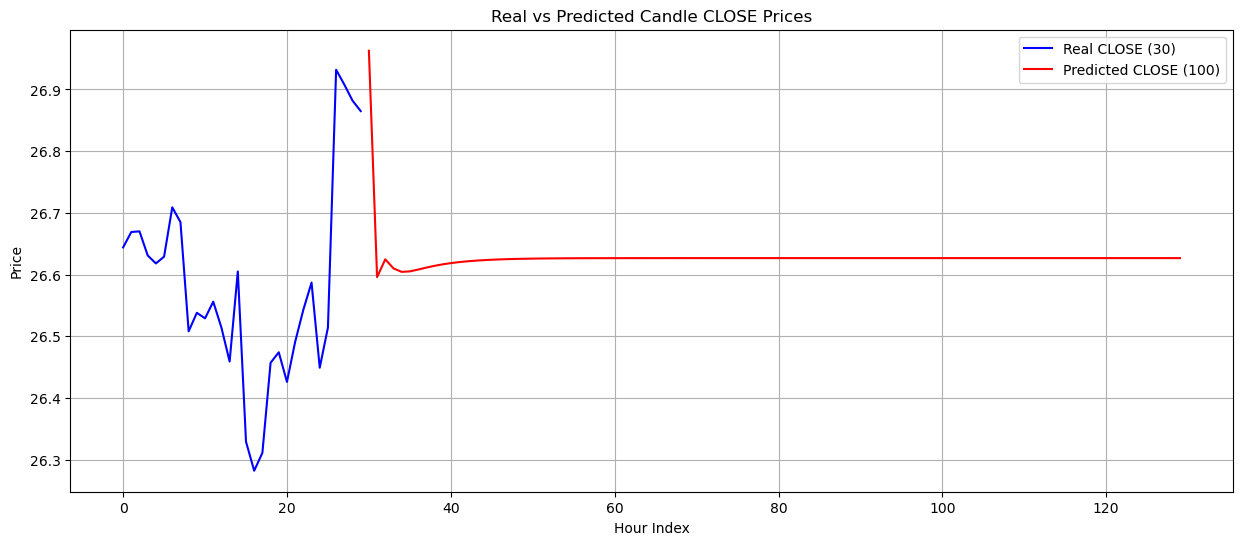

In [18]:
# 10. Plotting 30 Real + 100 Predicted Candles (CLOSE Price)
real_close = recent_df['<CLOSE>'].values
pred_close = predicted_candles[:, 3]  # index 3 = CLOSE

plt.figure(figsize=(15, 6))
plt.plot(range(30), real_close, label='Real CLOSE (30)', color='blue')
plt.plot(range(30, 130), pred_close, label='Predicted CLOSE (100)', color='red')
plt.title('Real vs Predicted Candle CLOSE Prices')
plt.xlabel('Hour Index')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()
